In [1218]:
import os
import contextily as ctx
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import sqrt
from scipy.spatial import cKDTree
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
from scipy.stats import zscore
from statsmodels import robust
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from logger import ExperimentLogger

# Random Forest

## Load data

In [1219]:
current_dir = os.getcwd()
well_filter = 1

data_path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}_ahn_elevation.csv")
testing_path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}_BEST.csv")

In [1220]:
df = pd.read_csv(data_path)
print(len(df))

7620


In [1222]:
df_test_new = pd.read_csv(testing_path)
print(len(df_test_new))

1760


In [1223]:
cols_to_drop = [
    'maximumacidity_1', 'fedith_1', 'siltcontent_1', 'maximumsandmedian_1',
    'maximumloamcontent_1', 'minimumloamcontent_1', 'cnratio_1',
    'calciccontent_1', 'minimumsandmedian_1', 'sandmedian_1', 'loamcontent_1',
    'minimumacidity_1', 'peattype_1'
]

# Drop for df
existing_cols_df = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=existing_cols_df)

# Drop for df_test_new
existing_cols_df_test_new = [col for col in cols_to_drop if col in df_test_new.columns]
df_test_new = df_test_new.drop(columns=existing_cols_df_test_new)

## Sort by date

In [1224]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
len(df)

7620

In [1225]:
# sort by date
df_test_new["date"] = pd.to_datetime(df_test_new["date"])
df_test_new = df_test_new.sort_values("date").reset_index(drop=True)
len(df_test_new)

1760

## Feature engineering

In [1226]:
# df['month_sin'] = np.sin(2*np.pi*df['date'].dt.month/12)
# df['month_cos'] = np.cos(2*np.pi*df['date'].dt.month/12)

In [1227]:
print(df.columns)
print(df_test_new.columns)

Index(['bro-id', 'nitrate', 'geometry', 'date', 'landuse code', 'soil region',
       'population', 'elevation', 'lon', 'lat', 'precipitation', 'temperature',
       'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1',
       'density_1', 'acidity_1', 'groundwater_depth'],
      dtype='object')
Index(['bro-id', 'nitrate', 'geometry', 'date', 'landuse code', 'soil region',
       'population', 'groundwater_depth', 'elevation', 'lon', 'lat',
       'precipitation', 'temperature', 'n deposition',
       'mainsoilclassification_1', 'organicmattercontent_1', 'density_1',
       'acidity_1'],
      dtype='object')


## Remove some columns and rows

--> By dropping Nan we exclude nitrate points that fall under city areas

In [1228]:
# df = df.drop(columns=['soil region', 'peattype_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'minimumsandmedian_1', 'siltcontent_1'])
# df = df.drop(columns=['landuse code'])
# df = df.drop(columns=['soil region', 'peattype_1'])
df = df.drop(columns=['soil region'])

df = df.dropna()
len(df)

5341

In [1229]:
df_test_new = df_test_new.drop(columns=['soil region'])

df_test_new = df_test_new.dropna()
len(df_test_new)

952

## Add month and year as a feature

In [1230]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

In [1231]:
df_test_new["month"] = df_test_new["date"].dt.month
df_test_new["year"] = df_test_new["date"].dt.year

In [1232]:
# def add_neighbor_mean(df, value_col='nitrate', n_neighbors=2):
#     # Make a copy to avoid modifying the original
#     df = df.copy()
#     df['neighbor_mean'] = np.nan
    
#     # Group by year and month
#     for (year, month), group in df.groupby(['year', 'month']):
#         # Use only wells with valid lat/lon and value
#         mask = group[['lon', 'lat', value_col]].notnull().all(axis=1)
#         wells = group[mask]
#         if len(wells) < n_neighbors + 1:
#             continue  # Not enough data
        
#         coords = wells[['lon', 'lat']].values
#         tree = cKDTree(coords)
        
#         # For each well in this (year, month), find nearest neighbors
#         for idx, row in wells.iterrows():
#             # Query for n_neighbors+1 because the first neighbor is itself
#             dists, indices = tree.query([row['lon'], row['lat']], k=n_neighbors+1)
#             # Exclude itself (distance==0)
#             neighbor_indices = indices[1:n_neighbors+1]
#             neighbor_vals = wells.iloc[neighbor_indices][value_col].values
#             mean_val = np.mean(neighbor_vals)
#             df.at[idx, 'neighbor_mean'] = mean_val
    
#     return df

# df = add_neighbor_mean(df, value_col='nitrate', n_neighbors=2)

In [1233]:
df = df.dropna()
len(df)

5341

In [1234]:
df_test_new = df_test_new.dropna()
len(df_test_new)

952

## Change column type

In [1235]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [1236]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df_test_new.columns:
        df_test_new[col] = df_test_new[col].astype('category')

## Remove nitrate outliers

<Axes: >

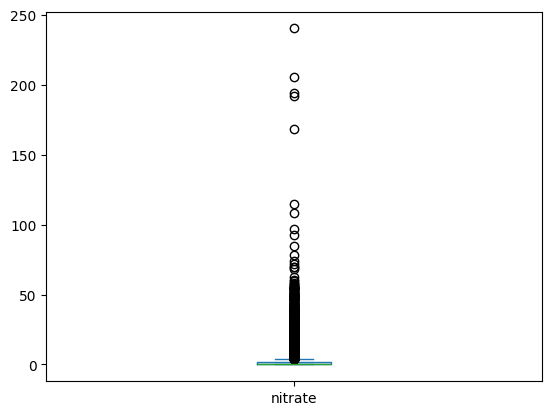

In [1237]:
df[["nitrate"]].plot(kind = "box")

<Axes: >

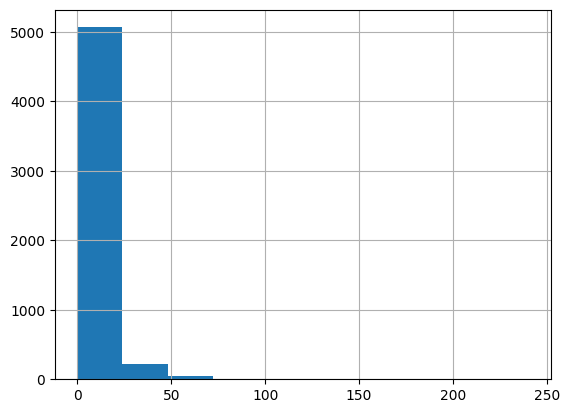

In [1238]:
df["nitrate"].hist()

In [1239]:
len(df[df["nitrate"] >= 10])

654

In [1240]:
# top_nitrate_outliers = list(df["nitrate"].sort_values()[-10:].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

In [1241]:
# top_nitrate_outliers = list(df_test_new["nitrate"].sort_values()[-100:].index)
# top_nitrate_outliers
# df_test_new = df_test_new.drop(top_nitrate_outliers)
# len(df_test_new)

## Test / train split

In [1242]:
# Define the split by year
train_years = list(range(2008, 2021))
test_years = [2021, 2022, 2023]
test_new_years = [2021, 2022, 2023]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()
test_df_new = df_test_new[df_test_new["year"].isin(test_new_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")
print(f"Test new: {len(test_df_new)}")

Train: 4458
Test: 883
Test new: 178


## Outliers

Select method that works the best

In [1243]:
def get_outlier_mask(s, method='iqr', factor=1.5, z_thresh=3, mad_thresh=3.5, 
                     lower_pct=0.01, upper_pct=0.99, contamination=0.01, X=None, 
                     dbscan_eps=0.5, dbscan_min_samples=5, domain_range=None):

    if method == 'iqr':
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - factor * iqr, q3 + factor * iqr
        return (s >= lower) & (s <= upper)

    elif method == 'zscore':
        z = zscore(s, nan_policy='omit')
        return np.abs(z) < z_thresh

    elif method == 'mad':
        median = np.median(s)
        mad = robust.mad(s)
        z = 0.6745 * (s - median) / mad if mad else np.zeros_like(s)
        return np.abs(z) < mad_thresh

    elif method == 'percentile':
        lower, upper = s.quantile([lower_pct, upper_pct])
        return (s >= lower) & (s <= upper)

    elif method == 'isoforest':
        if X is None: raise ValueError("X (DataFrame) required for Isolation Forest.")
        iso = IsolationForest(contamination=contamination, random_state=42)
        outlier_pred = iso.fit_predict(X)
        return outlier_pred == 1

    elif method == 'lof':
        if X is None: raise ValueError("X (DataFrame) required for LOF.")
        lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
        outlier_pred = lof.fit_predict(X)
        return outlier_pred == 1

    elif method == 'dbscan':
        if X is None: raise ValueError("X (DataFrame) required for DBSCAN.")
        db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(X)
        return db.labels_ != -1

    elif method == 'domain':
        if domain_range is None: raise ValueError("Specify domain_range=(min, max) for 'domain' method.")
        lower, upper = domain_range
        return (s >= lower) & (s <= upper)

    else:
        raise ValueError(f"Unknown outlier removal method: {method}")


outlier_method = "iqr"  # or "zscore", "mad", "percentile", "isoforest", etc.
lower, upper = 0, 100
domain_range=(lower, upper)

# Univariate example (apply only to train, get bounds, then apply same to test)
mask_train = get_outlier_mask(train_df['nitrate'], method=outlier_method, X=train_df)
lb, ub = train_df.loc[mask_train, 'nitrate'].min(), train_df.loc[mask_train, 'nitrate'].max()  # For some methods, like IQR

train_df = train_df[mask_train]
test_df = test_df[(test_df['nitrate'] >= lb) & (test_df['nitrate'] <= ub)]
test_df_new = test_df_new[(test_df_new['nitrate'] >= lb) & (test_df_new['nitrate'] <= ub)]

print(f"Train rows after outlier filter: {len(train_df):,}")
print(f"Test  rows after outlier filter: {len(test_df):,}")
print(f"Test New rows after outlier filter: {len(test_df_new):,}")


Train rows after outlier filter: 3,583
Test  rows after outlier filter: 754
Test New rows after outlier filter: 172


In [1244]:
# def iqr_bounds(s, factor: float = 1.5):
#     """Return (lower, upper) IQR bounds for a Series."""
#     q1, q3 = s.quantile([0.25, 0.75])
#     iqr = q3 - q1
#     return q1 - factor * iqr, q3 + factor * iqr

# lb, ub = iqr_bounds(train_df['nitrate'])      # ← only training stats
# train_df = train_df[(train_df['nitrate'] >= lb) & (train_df['nitrate'] <=  ub)]
# test_df  = test_df [(test_df ['nitrate'] >= lb) & (test_df ['nitrate'] <=  ub)]

# print(f"Train rows after outlier filter: {len(train_df):,}")
# print(f"Test  rows after outlier filter: {len(test_df):,}")

In [1245]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

X_test_new = test_df_new.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test_new = test_df_new["nitrate"]

## Preprocess data

In [1246]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [1247]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['landuse code', 'mainsoilclassification_1']
Numerical: ['population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1', 'groundwater_depth']
All X_train columns: ['landuse code', 'population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1', 'groundwater_depth']


In [1248]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [1249]:
rf_model = RandomForestRegressor(random_state=123, oob_score=False)

In [1250]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("rf", rf_model)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

In [1251]:
# param_grid = {
#     "regressor__rf__n_estimators": [50, 70, 100, 150],
#     "regressor__rf__max_features": ["sqrt", 0.2, 0.5, 0.7],
#     "regressor__rf__max_depth": [None, 5, 8, 10],
#     "regressor__rf__min_samples_split": [2, 4, 6, 8],
#     "regressor__rf__min_samples_leaf": [3, 4, 5]
# }

# param_grid = {
#     'regressor__rf__n_estimators': [50, 100, 150, 170, 200],
#     'regressor__rf__max_depth': [5, 10, 15, None],
#     'regressor__rf__min_samples_split': [2, 4, 8, 10],
#     'regressor__rf__min_samples_leaf': [1, 2, 4, 6],
#     'regressor__rf__max_features': ['sqrt', 0.3, 0.5, 1.0]
# }

param_grid = {
    'regressor__rf__n_estimators': [200],
    'regressor__rf__max_depth': [15],
    'regressor__rf__min_samples_split': [2],
    'regressor__rf__min_samples_leaf': [1],
    'regressor__rf__max_features': [0.5]
}

## Hyperparameter tuning

In [1252]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_grid,
    n_iter=60,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    random_state=123,
    verbose=1
)

# search.fit(X_train, y_train, **fit_params)

search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=60. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [1253]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 0.24396091612867893
Best params: {'regressor__rf__n_estimators': 200, 'regressor__rf__min_samples_split': 2, 'regressor__rf__min_samples_leaf': 1, 'regressor__rf__max_features': 0.5, 'regressor__rf__max_depth': 15}


## Learning curve

In [1254]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [1255]:
n = len(X_train)

train_errors = []
val_errors = []
train_stds = []
val_stds = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]
    w_subset = sample_weight.iloc[:split_idx].values

    tscv = TimeSeriesSplit(n_splits=5)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]
        w_tr = w_subset[train_idx] 

        model = clone(best_model)
        model.fit(X_tr, y_tr, rf__sample_weight=w_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    # Store mean and std
    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))

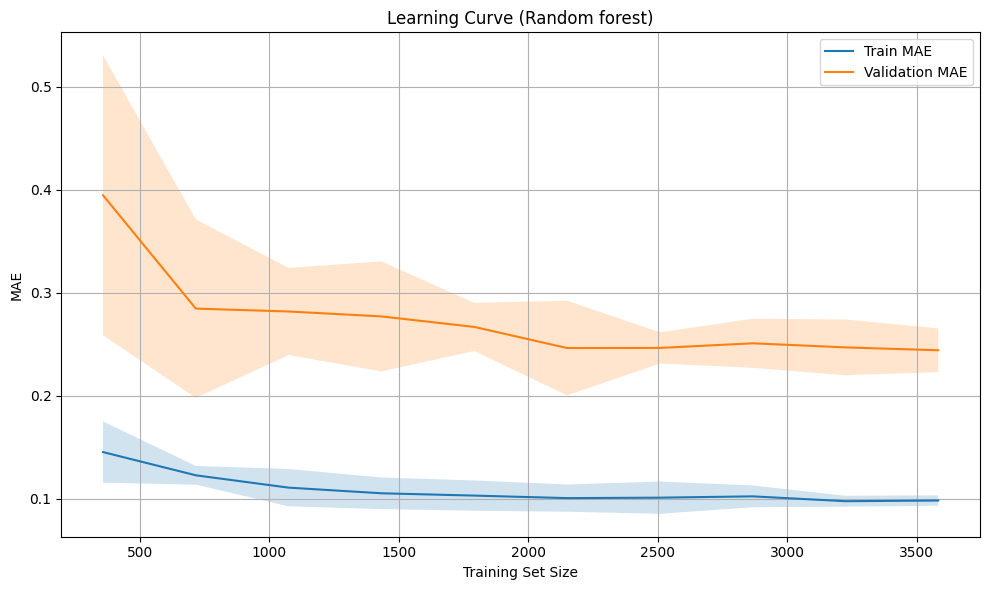

In [1256]:
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve (Random forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

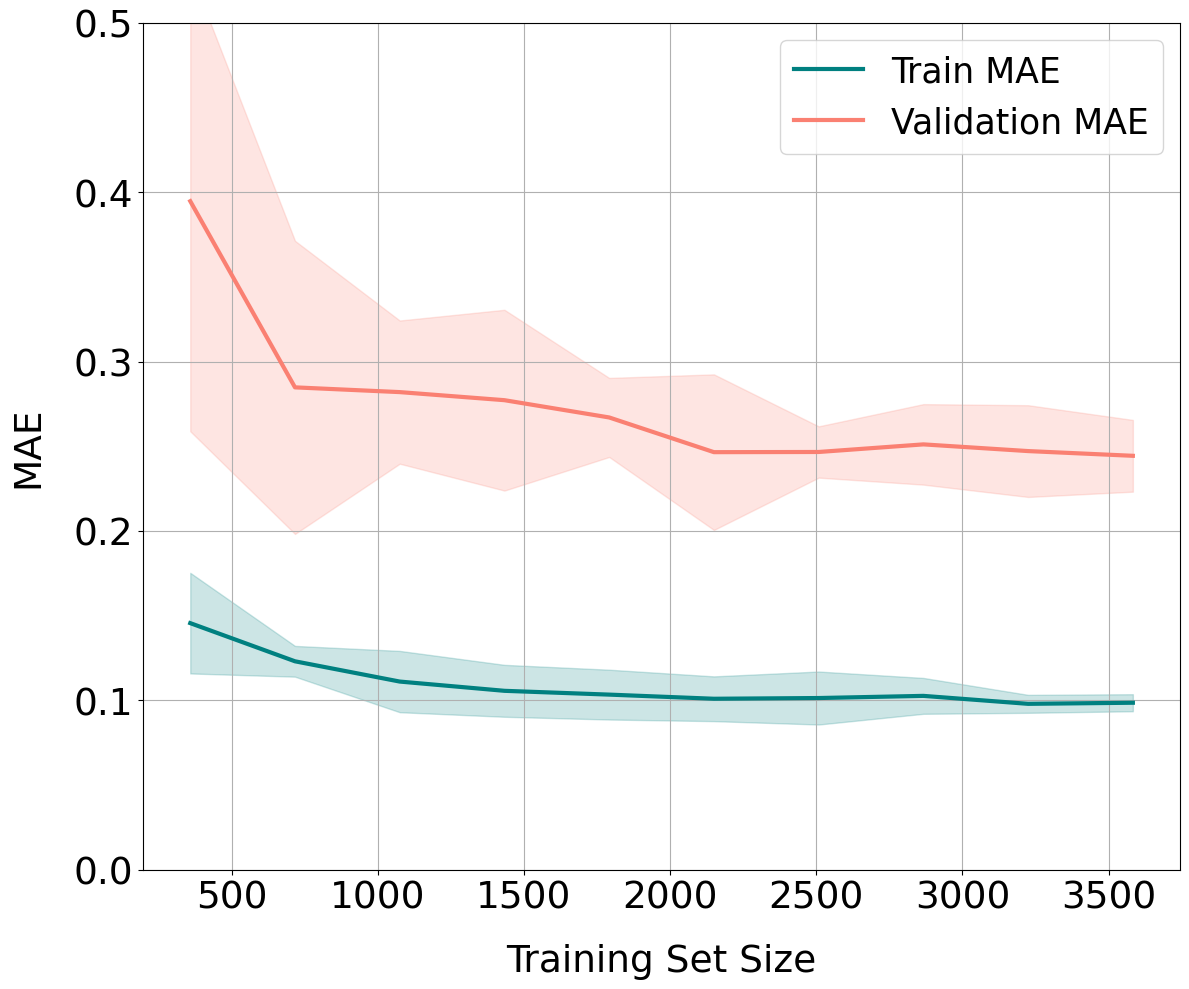

In [1257]:
import matplotlib.pyplot as plt

train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(12, 10))

plt.plot(train_sizes_abs, train_errors, label="Train MAE", color="teal", linewidth=3)  
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2, color="teal")

plt.plot(train_sizes_abs, val_errors, label="Validation MAE", color="salmon", linewidth=3)
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2, color="salmon")

plt.xlabel("Training Set Size", fontsize=27, labelpad=20)
plt.ylabel("MAE", fontsize=27, labelpad=20)
# plt.title("Learning Curve (Random Forest)", fontsize=16)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=25)
plt.ylim(0, 0.5)
plt.grid(True)
plt.tight_layout()
plt.show()


## Train model

In [1258]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1',
                                                                                        'groundwater_depth'])])),
                                                     ('rf',
                                                      RandomForestRegressor(max_depth=15,
                                                                            max_features=0.5,
                                                                            n_estimators=200,
                                                                            random_state=123))]))

## Final Train score

In [1259]:
pred_train = best_model.predict(X_train)

train_r2 = r2_score(y_train, pred_train)
train_mae = mean_absolute_error(y_train, pred_train)
train_rmse = sqrt(mean_squared_error(y_train, pred_train))

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.8768816353002931
Train MAE: 0.09754648083457891
Test RMSE: 0.2939646629288795


## Final Test score

In [1260]:
pred_nitrate = best_model.predict(X_test)

test_r2 = r2_score(y_test, pred_nitrate)
test_mae = mean_absolute_error(y_test, pred_nitrate)
test_rmse = sqrt(mean_squared_error(y_test, pred_nitrate))

print("Test R2:", test_r2)
print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)

Test R2: 0.5419997464154085
Test MAE: 0.24560821016943013
Test RMSE: 0.5626712055145704


## Final New Test score

In [1261]:
pred_nitrate_new = best_model.predict(X_test_new)

test_new_r2 = r2_score(y_test_new, pred_nitrate_new)
test_new_mae = mean_absolute_error(y_test_new, pred_nitrate_new)
test_new_rmse = sqrt(mean_squared_error(y_test_new, pred_nitrate_new))

print("Test new R2:", test_new_r2)
print("Test new MAE:", test_new_mae)
print("Test new RMSE:", test_new_rmse)

Test new R2: 0.3910594650305824
Test new MAE: 0.20317128300094772
Test new RMSE: 0.5870053222716879


In [1262]:
len(y_test_new)

172

## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

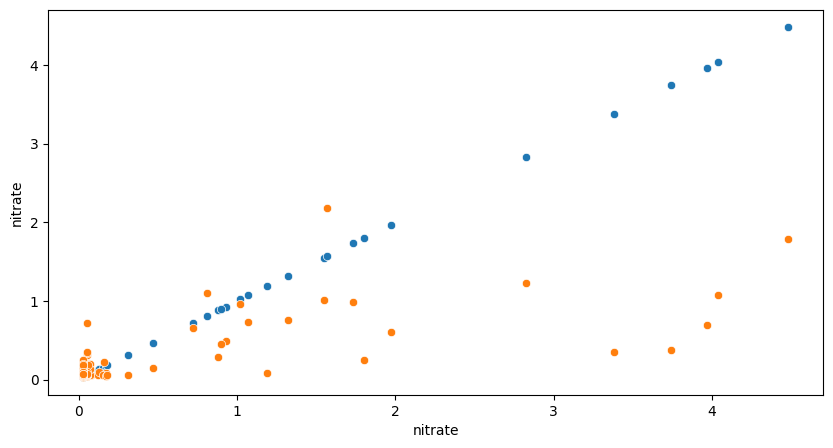

In [1263]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test_new, y = y_test_new, ax = ax)
sns.scatterplot(x = y_test_new, y = pred_nitrate_new, ax = ax)

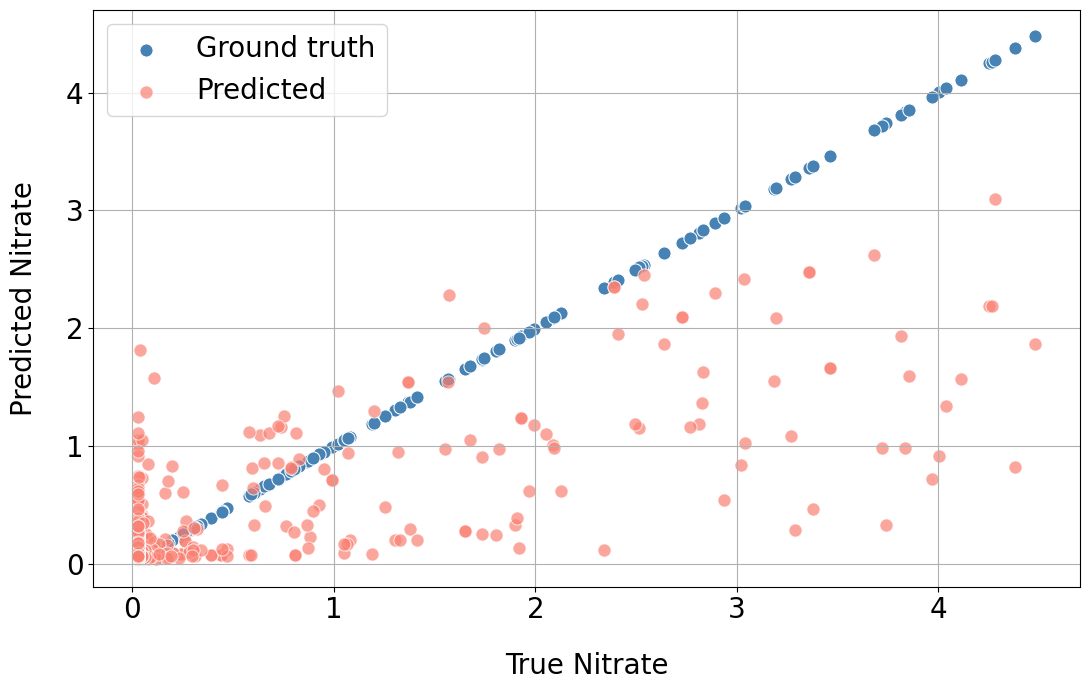

In [1264]:
fig, ax = plt.subplots(figsize=(11, 7))

sns.scatterplot(x=y_test, y=y_test, ax=ax, label="Ground truth", s=90, color="steelblue")

sns.scatterplot(x=y_test, y=pred_nitrate, ax=ax, label="Predicted", s=90, color="salmon", alpha=0.7)

ax.set_xlabel("True Nitrate", fontsize=20, labelpad=20)
ax.set_ylabel("Predicted Nitrate", fontsize=20, labelpad=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
ax.grid(True)

plt.tight_layout()
plt.show()

## Residuals

(-2.042475988237791, 12.0)

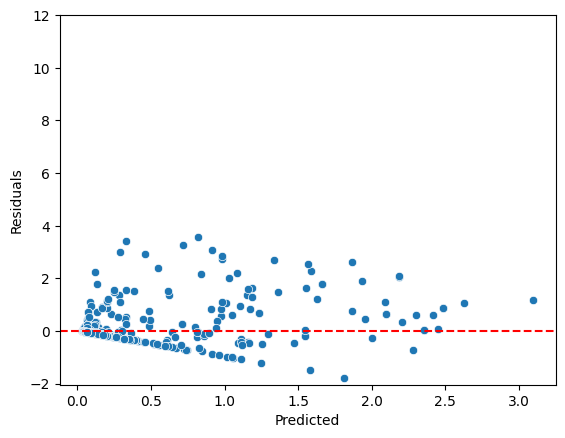

In [1265]:
preds = best_model.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.ylim(top=12)

In [1266]:
residuals.to_csv("rf_residuals.csv")

## Predictions on the map

In [1267]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

754
754
754
754


In [1268]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

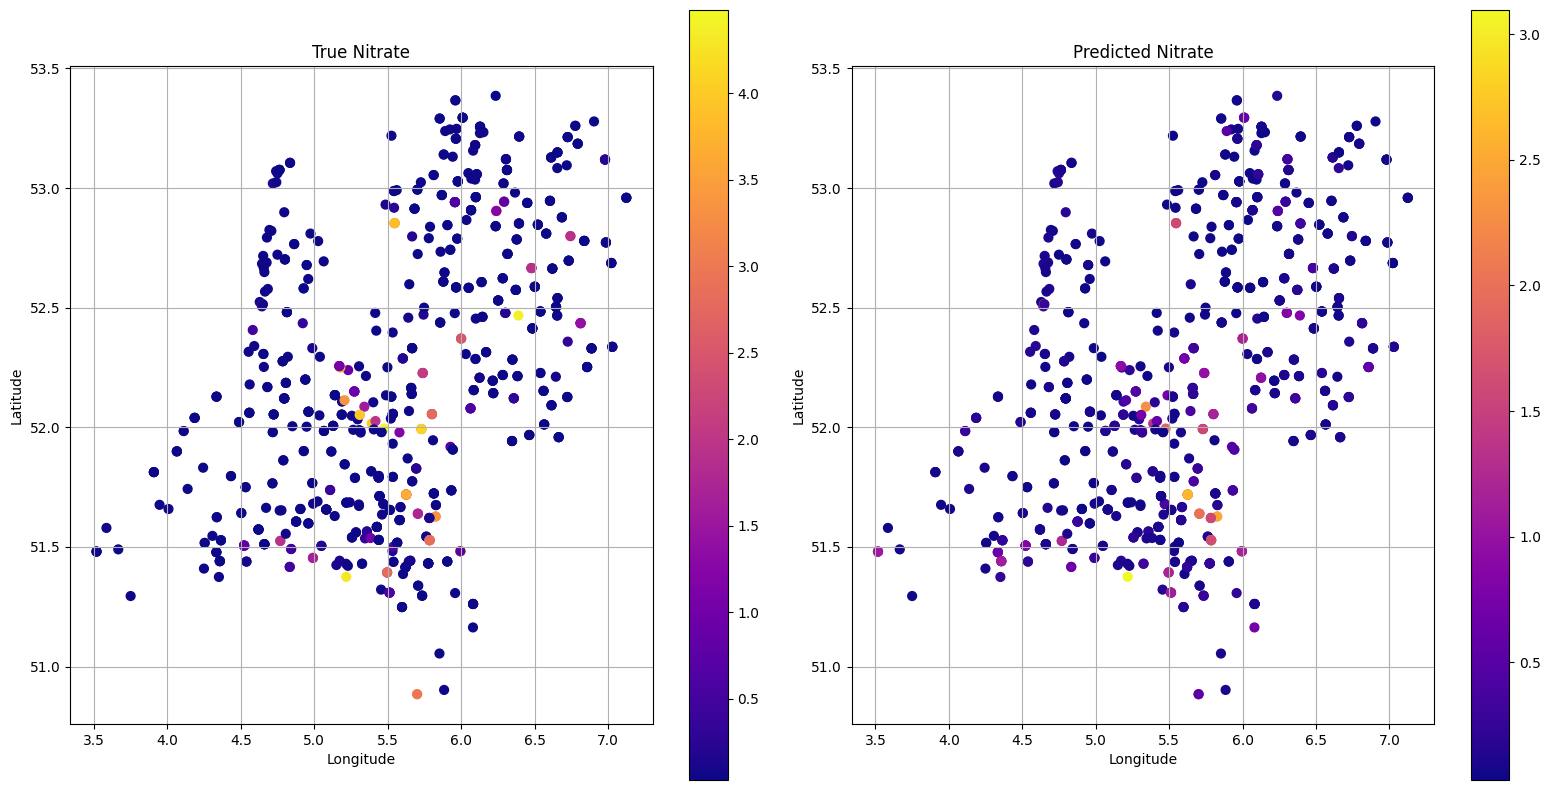

In [1269]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

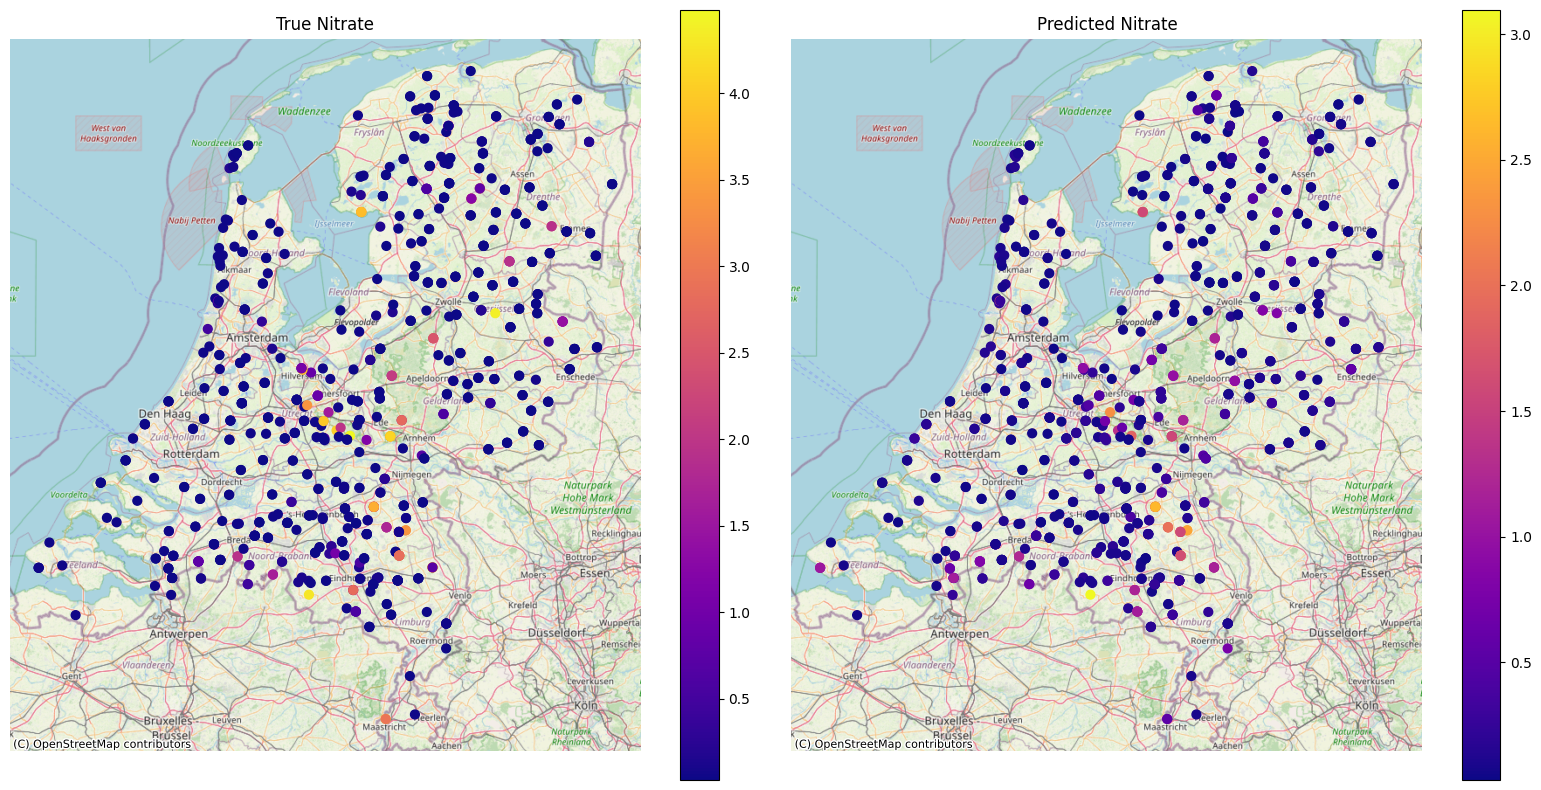

In [1270]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

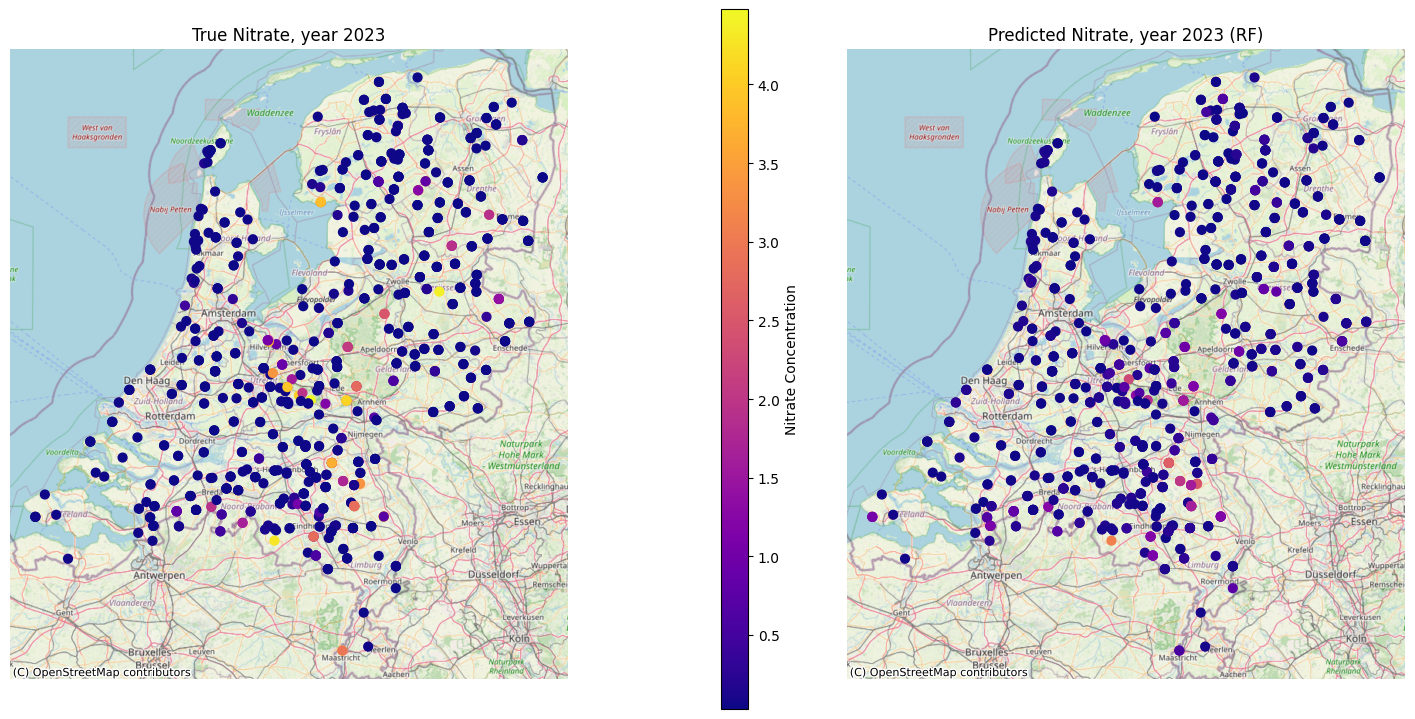

In [1271]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

gdf_3857 = gdf.to_crs(epsg=3857)

vmin = min(gdf_3857["nitrate_true"].min(), gdf_3857["nitrate_pred"].min())
vmax = max(gdf_3857["nitrate_true"].max(), gdf_3857["nitrate_pred"].max())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.plasma
sm = ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

fig, axs = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={"wspace": 0.5})

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate, year 2023")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate, year 2023 (RF)")

for ax in axs:
    ax.set_axis_off()

cbar_ax = fig.add_axes([0.52, 0.15, 0.015, 0.7])
fig.colorbar(sm, cax=cbar_ax, label="Nitrate Concentration")

plt.show()


## Feature importances

--> Gain (by default) how much each feature, on average, reduces the impurity (MSE or Gini)

In [1272]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1',
                                                                                        'groundwater_depth'])])),
                                                     ('rf',
                                                      RandomForestRegressor(max_depth=15,
                                                                            max_features=0.5,
                                                                            n_estimators=200,
                                                                            random_state=123))]))

In [1273]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [1274]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['rf']

feature_names = fitted_preprocessor.get_feature_names_out()

importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                          feature  importance
61  num_scaler__groundwater_depth    0.160774
60          num_scaler__acidity_1    0.146924
57       num_scaler__n deposition    0.129268
54          num_scaler__elevation    0.108414
59          num_scaler__density_1    0.078405
..                            ...         ...
21     cat_ohe__landuse code_32.0    0.000013
31     cat_ohe__landuse code_42.0    0.000013
23     cat_ohe__landuse code_34.0    0.000003
28     cat_ohe__landuse code_39.0    0.000001
29     cat_ohe__landuse code_40.0    0.000001

[62 rows x 2 columns]


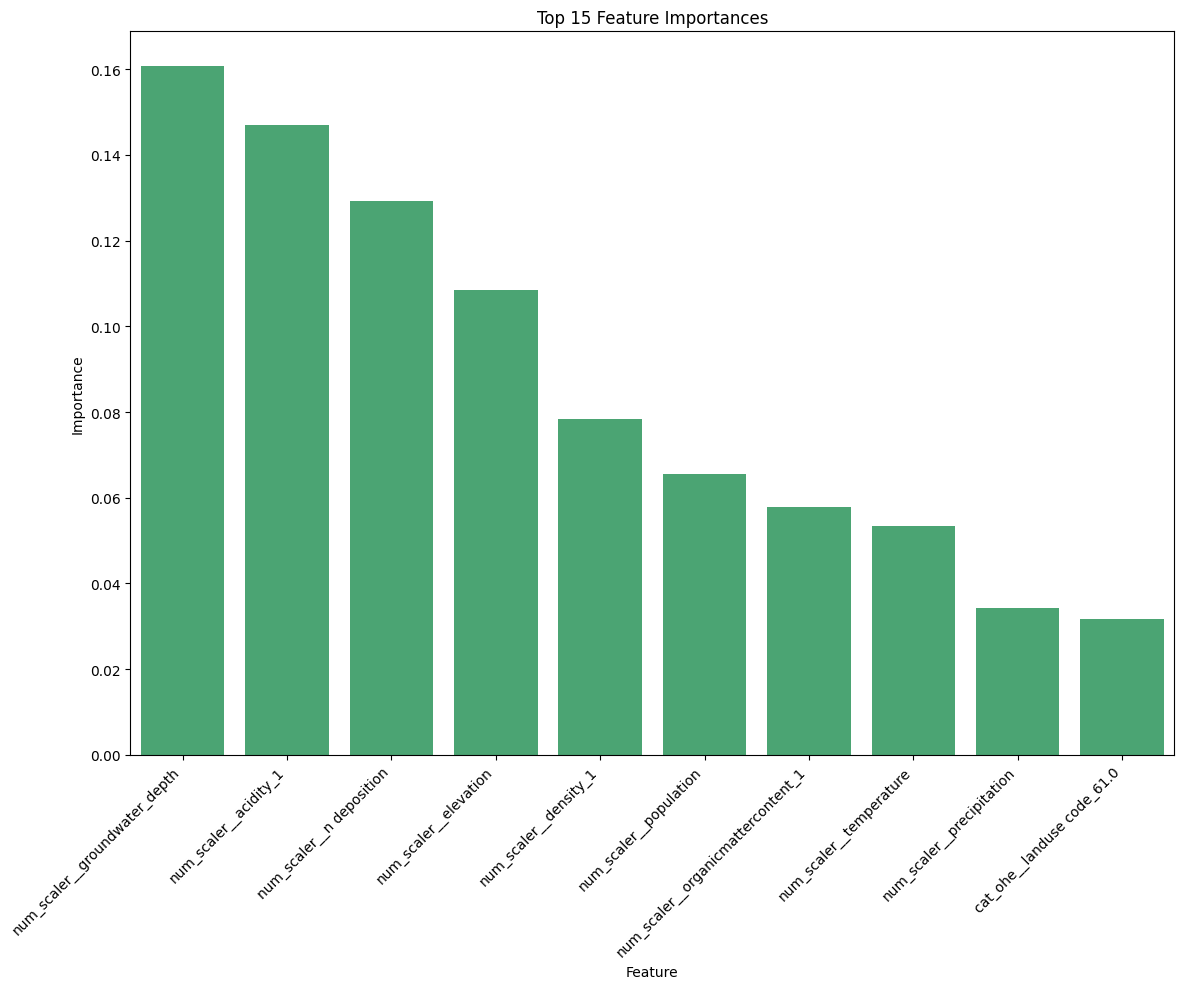

In [1275]:
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x="Feature", y="Importance", data=fi_df.head(10), color="mediumseagreen")
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [1276]:
# --- Keep:
# organiccontent
# elevation
# soil code
# acidity
# groundwater depth
# density
# population
# precipitation
# n_deposition
# temperature

# --- Remove:
# landuse
# soil region
# month

## Logging

In [ ]:
curr_dir = os.getcwd()
log_path = os.path.join(curr_dir, '../../logging/experiment_log.json')

# After each notebook run, do this!
logger = ExperimentLogger(save_path=log_path)

# if not outlier_method:

model = "Random Forest"
hyperparams = search.best_params_
outlier_method = None
train_score = {"R2": train_r2, "MAE": train_mae, "RMSE": train_rmse}
test_score = {"R2": test_r2, "MAE": test_mae, "RMSE": test_rmse}
data_file_name = data_path

logger.log(
    model = model,
    data_file = data_file_name,
    features = df.columns,
    hyperparams=hyperparams,
    outlier_method=outlier_method,
    train_score=train_score,
    test_score=test_score,
    extra_info={"note": "Removed soil region"}
)

# Model-Agnostic

In [877]:
# Transform X_test using preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

In [ ]:
# Use minimal SHAP setup (no deep or tree models)
from shap.explainers import Kernel
import lime.lime_tabular
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Safe SHAP wrapper
def shap_predict(X_array):
    X_df = pd.DataFrame(X_array, columns=X_test.columns)
    return best_model.predict(X_df)

# Background data
X_background = X_train.sample(100, random_state=0)
explainer_shap = Kernel(shap_predict, X_background)
shap_values = explainer_shap.shap_values(X_test.iloc[:50])

# SHAP plot
import shap
shap.summary_plot(shap_values, X_test.iloc[:50])

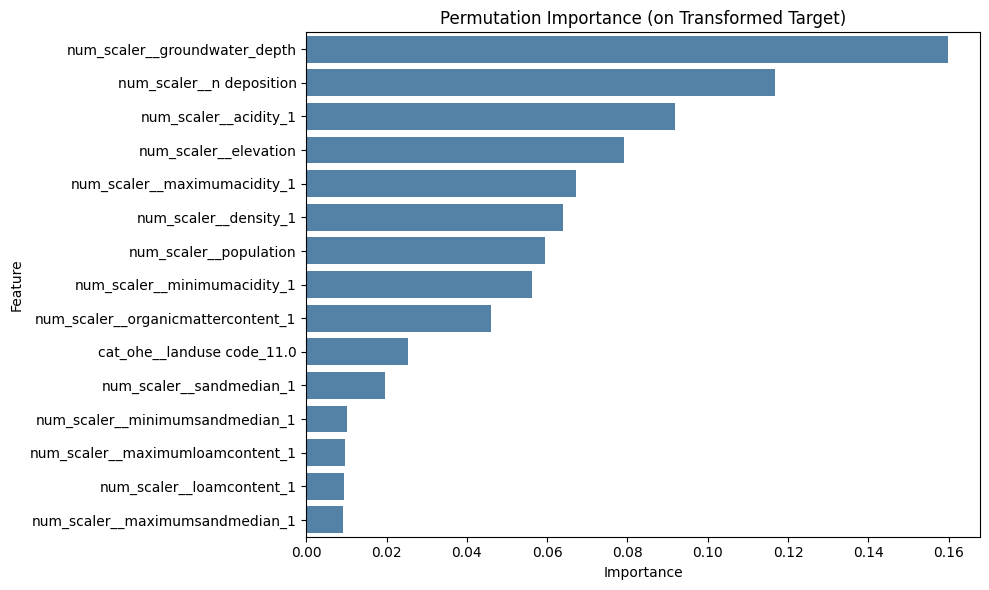

In [432]:
# If your target was transformed using log1p, reverse it before comparing
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

# Run permutation importance
perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean
}).sort_values("Importance", ascending=False)

perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"


In [710]:
# import pandas as pd

# df_google = pd.read_csv('/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/aligned/merged_dataset_1_BEST.csv')
# df_ahn = pd.read_csv('/Users/Administrator/Downloads/merged_dataset_1_elvation_utr_flevo_zuid_noord.csv')

# # Replace the 'elevation' column in df_main
# df_google['elevation'] = df_ahn['elevation']

# # Save to a new file if needed
# df_google.to_csv('/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/aligned/merged_dataset_1_BEST.csv', index=False)
